In [1]:
# Necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plotting aesthetics / tweaking
plt.rcParams['figure.figsize'] = (15, 10)
plt.rc("axes", labelsize=18)
plt.rc("xtick", labelsize=16, top=True, direction="in")
plt.rc("ytick", labelsize=16, right=True, direction="in")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=10)
plt.rc("figure", figsize=(10, 7))
sns.set_style("darkgrid", {'axes.grid': False})
sns.set_context("paper")
sns.set_theme(font_scale=1.4)
mycolors = ['#C188F7', '#F79288', '#7FB806', '#F59B18']
sns.set_palette("Set2")

In [2]:
# CONSTANTS
e = 0.0167  # Earth's orbital eccentricity
lambda_p = 102.9372  # Longitude of perihelion in degrees
y = 0.043  # Related to Earth's axial tilt and ellipticity
days_in_year = 365  # Self-explanatory

# Locations
locations = {"Tenerife": {"latitude": 28.1800, "longitude": -16.3035}, # Source: IAC webpage (Longitude: 16º 30´ 35" West. Latitude: 28º 18´ 00" North)
             "MtKent": {"latitude": -28.0000, "longitude": 152.0000}}  # Source: UNISQ webpage (28S, 152E)

In [3]:
# Equation of time
def eot_precise(day_of_year):
    M = 2 * np.pi * (day_of_year - 3) / 365.24  # Note conversion between degrees in markdown text and radius here!!
    return -7.659 * np.sin(M) + 9.863 * np.sin(2 * M + np.radians(3.5932)) # Result in minutes


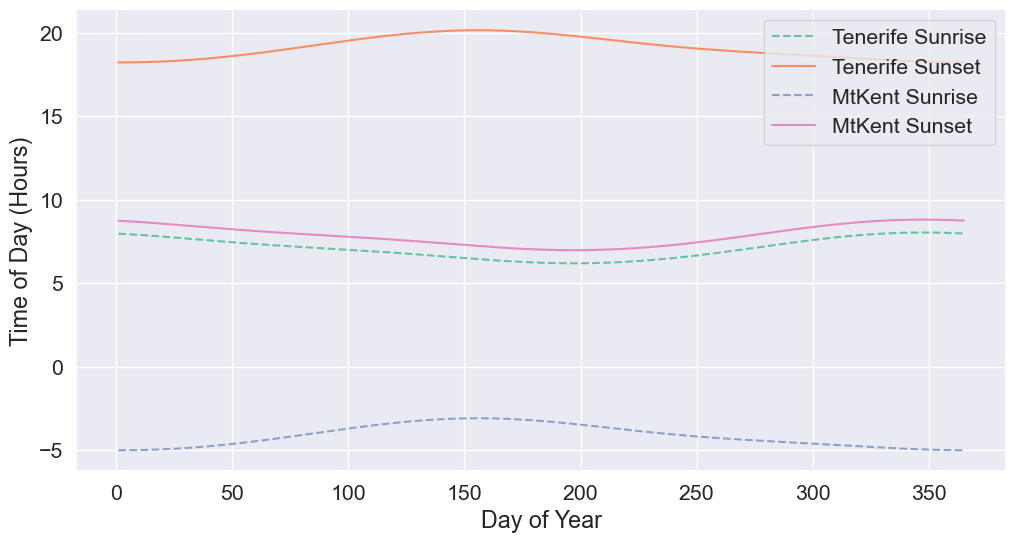

In [4]:
# Function to calculate declination of the sun
def declination(day_of_year):
    return np.arcsin(np.sin(np.radians(-23.44)) * np.cos(2 * np.pi * (day_of_year + 10) / 365.24))

# Function to calculate sunrise and sunset times
def calculate_sunrise_sunset(lat, lon, day_of_year, eot):
    lat_rad = np.radians(lat)
    decl = declination(day_of_year)
    
    # Calculate hour angle at sunrise/sunset
    cos_h = -np.tan(lat_rad) * np.tan(decl)
    # Prevent invalid values due to polar regions during extreme seasons
    cos_h = np.clip(cos_h, -1, 1)
    hour_angle = np.arccos(cos_h)
    
    # Convert hour angle to time (local solar time)
    sunrise = 12 - (np.degrees(hour_angle) / 15) - (eot / 60) - (lon / 15)
    sunset = 12 + (np.degrees(hour_angle) / 15) - (eot / 60) - (lon / 15)
    return sunrise, sunset

# Generate sunrise and sunset data for Tenerife and Mt. Kent
results = {"Day": [], "Location": [], "Sunrise": [], "Sunset": []}
for location, coords in locations.items():
    for day in range(1, days_in_year + 1):
        lat = coords["latitude"]
        lon = coords["longitude"]
        eot = eot_precise(day) 
        sunrise, sunset = calculate_sunrise_sunset(lat, lon, day, eot)
        results["Day"].append(day)
        results["Location"].append(location)
        results["Sunrise"].append(sunrise)
        results["Sunset"].append(sunset)

# Convert to DataFrame
sunrise_sunset_df = pd.DataFrame(results)

# Plot sunrise and sunset for both locations
plt.figure(figsize=(12, 6))
for location in locations.keys():
    subset = sunrise_sunset_df[sunrise_sunset_df["Location"] == location]
    plt.plot(subset["Day"], subset["Sunrise"], label=f"{location} Sunrise", linestyle='--')
    plt.plot(subset["Day"], subset["Sunset"], label=f"{location} Sunset")
    
plt.xlabel("Day of Year")
plt.ylabel("Time of Day (Hours)")
plt.legend()
plt.show()

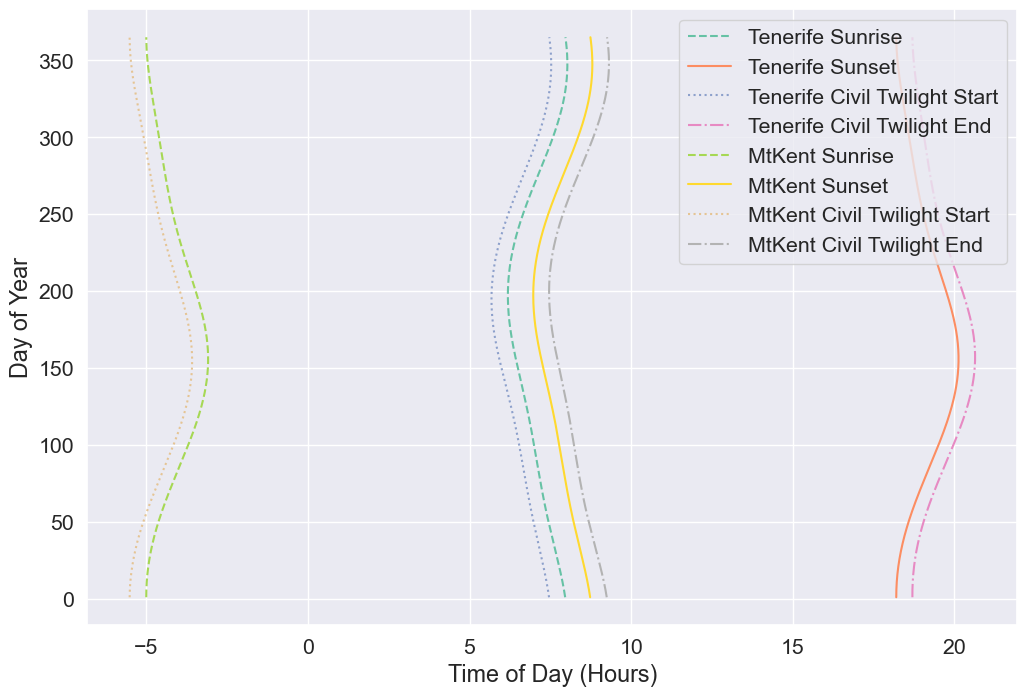

In [5]:
# Function to calculate twilight durations (civil twilight)
def calculate_twilight(lat, lon, day_of_year, eot, twilight_angle=-6):
    lat_rad = np.radians(lat)
    decl = declination(day_of_year)
    
    # Calculate hour angle for twilight
    cos_h_twilight = -np.tan(lat_rad) * np.tan(decl) + np.sin(np.radians(twilight_angle)) / np.cos(lat_rad) / np.cos(decl)
    cos_h_twilight = np.clip(cos_h_twilight, -1, 1)
    twilight_angle_rad = np.arccos(cos_h_twilight)
    
    # Convert hour angle to time (local solar time)
    sunrise_twilight = 12 - (np.degrees(twilight_angle_rad) / 15) - (eot / 60) - (lon / 15)
    sunset_twilight = 12 + (np.degrees(twilight_angle_rad) / 15) - (eot / 60) - (lon / 15)
    return sunrise_twilight, sunset_twilight

# Add twilight calculations
results["CivilTwilightStart"] = []
results["CivilTwilightEnd"] = []
for location, coords in locations.items():
    for day in range(1, days_in_year + 1):
        lat = coords["latitude"]
        lon = coords["longitude"]
        eot = eot_precise(day)
        civil_start, civil_end = calculate_twilight(lat, lon, day, eot, twilight_angle=-6)
        results["CivilTwilightStart"].append(civil_start)
        results["CivilTwilightEnd"].append(civil_end)

# Convert extended results to DataFrame
extended_df = pd.DataFrame(results)

# Plot swapping axes (Day on y-axis, Time on x-axis)
plt.figure(figsize=(12, 8))
for location in locations.keys():
    subset = extended_df[extended_df["Location"] == location]
    plt.plot(subset["Sunrise"], subset["Day"], label=f"{location} Sunrise", linestyle='--')
    plt.plot(subset["Sunset"], subset["Day"], label=f"{location} Sunset")
    plt.plot(subset["CivilTwilightStart"], subset["Day"], label=f"{location} Civil Twilight Start", linestyle=':')
    plt.plot(subset["CivilTwilightEnd"], subset["Day"], label=f"{location} Civil Twilight End", linestyle='-.')

plt.xlabel("Time of Day (Hours)")
plt.ylabel("Day of Year")
plt.legend()
plt.show()

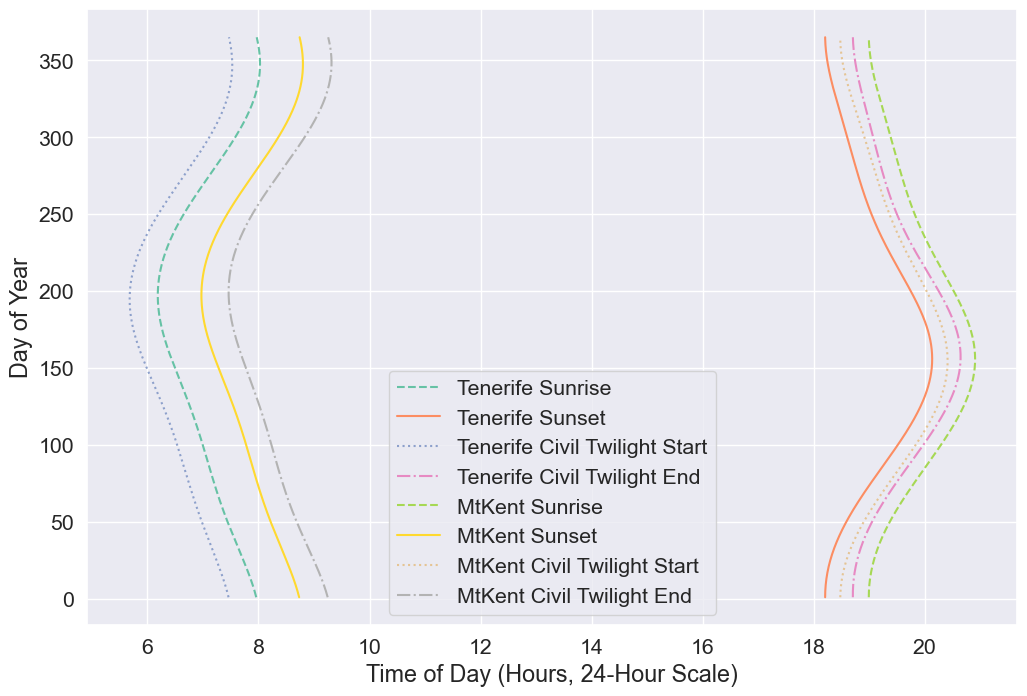

{'Polar Day Count': 0, 'Polar Night Count': 0}

In [6]:
# Adjust sunrise, sunset, and twilight times to a 24-hour cycle with noon at the center
def adjust_to_24_hour_cycle(times):
    """Adjust times to a 24-hour scale centered around 12:00."""
    adjusted = []
    for time in times:
        if time < 0:  # Wrap around for times before midnight
            adjusted.append(time + 24)
        elif time > 24:  # Handle any values beyond 24 hours
            adjusted.append(time - 24)
        else:
            adjusted.append(time)
    return adjusted

extended_df["Sunrise_Adjusted"] = adjust_to_24_hour_cycle(extended_df["Sunrise"])
extended_df["Sunset_Adjusted"] = adjust_to_24_hour_cycle(extended_df["Sunset"])
extended_df["CivilTwilightStart_Adjusted"] = adjust_to_24_hour_cycle(extended_df["CivilTwilightStart"])
extended_df["CivilTwilightEnd_Adjusted"] = adjust_to_24_hour_cycle(extended_df["CivilTwilightEnd"])

plt.figure(figsize=(12, 8))
for location in locations.keys():
    subset = extended_df[extended_df["Location"] == location]
    plt.plot(subset["Sunrise_Adjusted"], subset["Day"], label=f"{location} Sunrise", linestyle='--')
    plt.plot(subset["Sunset_Adjusted"], subset["Day"], label=f"{location} Sunset")
    plt.plot(subset["CivilTwilightStart_Adjusted"], subset["Day"], label=f"{location} Civil Twilight Start", linestyle=':')
    plt.plot(subset["CivilTwilightEnd_Adjusted"], subset["Day"], label=f"{location} Civil Twilight End", linestyle='-.')

plt.xlabel("Time of Day (Hours, 24-Hour Scale)")
plt.ylabel("Day of Year")
plt.legend()
plt.show()

# Highlighting Polar Day/Night Effects
polar_df = extended_df[(extended_df["Sunrise_Adjusted"] == 24) & (extended_df["Sunset_Adjusted"] == 24)]

polar_day_night_info = {
    "Polar Day Count": len(polar_df[polar_df["Location"] == "Tenerife"]),
    "Polar Night Count": len(polar_df[polar_df["Location"] == "MtKent"])
}
polar_day_night_info